In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'NLP_project/dataset'
assert FOLDERNAME is not None, "[!] Enter the foldername."

#Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1JLBuZnTQ8Cui6dbc8hlnFXrD_POoT_4F/NLP_project/dataset


In [ ]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [ ]:
!pip install transformers -q
!pip install pandarallel -q
!pip install sentencepiece -q
!pip install neptune-client -q


     |████████████████████████████████| 3.4 MB 6.8 MB/s 
     |████████████████████████████████| 596 kB 53.5 MB/s 
     |████████████████████████████████| 895 kB 70.7 MB/s 
     |████████████████████████████████| 3.3 MB 53.0 MB/s 
     |████████████████████████████████| 61 kB 553 kB/s 
     |████████████████████████████████| 1.2 MB 8.7 MB/s 
     |████████████████████████████████| 287 kB 8.6 MB/s 
     |████████████████████████████████| 829 kB 67.7 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 180 kB 75.5 MB/s 
     |████████████████████████████████| 131 kB 83.3 MB/s 
     |████████████████████████████████| 8.4 MB 55.6 MB/s 
     |████████████████████████████████| 79 kB 10.1 MB/s 
     |████████████████████████████████| 138 kB 74.8 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 127 kB 77.3 MB/s 
     |████████████████████████████████| 130 kB 87.1 MB/s 
     |██████████████████

In [ ]:
import numpy as np
import pandas as pd
import regex as re
import random
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,average_precision_score, precision_score,precision_recall_curve
from tqdm.notebook import tqdm
from tqdm import trange
import warnings
warnings.filterwarnings('ignore')
import pickle
import nltk
import math
import os
import json
import random
import re
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel



In [ ]:
reviews_df = pd.read_csv('/content/drive/MyDrive/NLP_project/dataset/yelp_preprocessed_1M.csv')


In [ ]:
print(reviews_df.columns)

Index(['Unnamed: 0', 'date', 'useful', 'text', 'cool', 'funny', 'review_id',
       'user_id', 'stars', 'business_id', 'sentiment'],
      dtype='object')


In [ ]:
reviews_df = reviews_df[0:100]

In [ ]:
model_path = '/content/drive/MyDrive/NLP_project/arg_miningrobertalarge_SEED_4_dense_layer_epoc_3_lr_1e-05_b_s_16_accumulation_steps_2_input_type_kp_arg_topic_preee.pt'

In [ ]:
class NonPoolerTransformer(torch.nn.Module):

    def __init__(self):
        super(NonPoolerTransformer, self).__init__()
        
        #Instantiating Pre trained model object 
        self.model_layer = AutoModel.from_pretrained(model_path)

        #Layers
        # the first dense layer will have 768 if base model is used and 
        # 1024 if large model is used

        self.dense_layer_1 = nn.Linear(1024, 256)
        self.dropout = nn.Dropout(0.4)
        self.dense_layer_2 = nn.Linear(256, 128)
        self.dropout_2 = nn.Dropout(0.2)
        self.cls_layer = nn.Linear(128, 1, bias = True)
        self.sigmoid = nn.Sigmoid()

    def forward(self,input_ids, attention_masks):

        hidden_state = self.model_layer(input_ids=input_ids, attention_mask=attention_masks)[0]
        pooled_output = hidden_state[:, 0]

        x = self.dense_layer_1(pooled_output)
        x = self.dropout(x)
        x_1 = self.dense_layer_2(x)
        x_2 = self.dropout_2(x_1)

        logits = self.cls_layer(x_2)
        output = self.sigmoid(logits)

        return output

In [ ]:
model = torch.load(model_path)
tokenizer = AutoTokenizer.from_pretrained('roberta-large')


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
#make reviews and key_points dataset
key_point_df =df = pd.read_csv('/content/drive/MyDrive/NLP_project/dataset/NLP keypoints - Restaurants.csv')
positive_kp_df = key_point_df['Positive']
# print(positive_kp_df.head())
negative_kp_df = key_point_df['Negative']
# print(negative_kp_df.head())

reviews_text_df = reviews_df['text']

reviews_list = reviews_text_df.values.tolist()
kp_list = positive_kp_df.values.tolist()
kp_list.extend(negative_kp_df.values.tolist())

print(reviews_list)
print(kp_list)

['b"Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. \\n\\nAfter reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don\'t offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and grana frita. Both were very good. We split a secondi which was the special Berkshire pork secreto, which was described as a pork skirt ste

In [ ]:
print(key_point_df.shape)

(60, 2)


In [ ]:
final_list = []

for review in reviews_list:
  for kp in kp_list:
    final_list.append([review,kp])

dataset = pd.DataFrame(final_list,columns = ['review','key_point'])

In [ ]:
print(dataset.head())

                                              review                         key_point
0  b"Apparently Prides Osteria had a rough summer...            The staff is top notch
1  b"Apparently Prides Osteria had a rough summer...                     Food is fresh
2  b"Apparently Prides Osteria had a rough summer...              Prices are very good
3  b"Apparently Prides Osteria had a rough summer...              Super fast and cheap
4  b"Apparently Prides Osteria had a rough summer...  The staff was nice and attentive


In [ ]:
from torch.utils.data import (DataLoader, RandomSampler, WeightedRandomSampler, SequentialSampler, TensorDataset)



In [ ]:
def matching_score(dataframe):
  all_attention_masks=[]
  all_input_ids=[]
  match_scores = []

  #print(dataframe.shape[0])
  for i in range(dataframe.shape[0]):
    encoded_input = tokenizer(dataframe.iloc[i]['all_text'], padding='max_length')
    #print(encoded_input['attention_mask'])
    # print(len(encoded_input['attention_mask']))
    all_attention_masks.append(encoded_input['attention_mask'][0:512])
    all_input_ids.append(encoded_input['input_ids'][0:512])

  all_attention_masks = torch.tensor(all_attention_masks).squeeze()
  all_input_ids = torch.tensor(all_input_ids).squeeze()


  dataset = TensorDataset(all_input_ids, all_attention_masks)


  test_dataloader = DataLoader(dataset, batch_size=1)
      
  with torch.no_grad():
      acc_epoch = []

      epoch_iterator = tqdm(test_dataloader, desc="Iteration")
      for step, batch in enumerate(epoch_iterator):
          model.eval()
              

          b_input_ids, b_input_mask = batch[0].to(device), batch[1].to(device)
          ypred = model(b_input_ids, b_input_mask)
          # print(ypred)
          match_scores.append(ypred[0][0].item())
  return match_scores


In [ ]:
sentence_df = pd.DataFrame([], columns =['Review', 'Sentence', 'Key_point'])

In [ ]:
sentence_df.shape

(0, 3)

In [ ]:
for index, row in dataset.iterrows():
  if row.review!= None:
    splitted = row.review.split('.')
    for sentence in splitted:
      print(sentence)
      new_row = [row.review, sentence, row.key_point]
      sentence_df.loc[len(sentence_df.index)] = new_row
  else:
      continue

In [ ]:
sentence_df.head()

,Review,Sentence,Key_point
0,"b""Apparently Prides Osteria had a rough summer...","b""Apparently Prides Osteria had a rough summer...",The staff is top notch
1,"b""Apparently Prides Osteria had a rough summer...",However new blood in the kitchen seems to hav...,The staff is top notch
2,"b""Apparently Prides Osteria had a rough summer...",Waitstaff was warm but unobtrusive,The staff is top notch
3,"b""Apparently Prides Osteria had a rough summer...",By 8 pm or so when we left the bar was full a...,The staff is top notch
4,"b""Apparently Prides Osteria had a rough summer...",Perhaps Beverly residents prefer a later seating,The staff is top notch


In [ ]:
sentence_df['all_text'] = sentence_df['Sentence']+sentence_df['Key_point']

In [ ]:
sentence_df.head()

,Review,Sentence,Key_point,all_text
0,"b""Apparently Prides Osteria had a rough summer...","b""Apparently Prides Osteria had a rough summer...",The staff is top notch,"b""Apparently Prides Osteria had a rough summer..."
1,"b""Apparently Prides Osteria had a rough summer...",However new blood in the kitchen seems to hav...,The staff is top notch,However new blood in the kitchen seems to hav...
2,"b""Apparently Prides Osteria had a rough summer...",Waitstaff was warm but unobtrusive,The staff is top notch,Waitstaff was warm but unobtrusiveThe staff i...
3,"b""Apparently Prides Osteria had a rough summer...",By 8 pm or so when we left the bar was full a...,The staff is top notch,By 8 pm or so when we left the bar was full a...
4,"b""Apparently Prides Osteria had a rough summer...",Perhaps Beverly residents prefer a later seating,The staff is top notch,Perhaps Beverly residents prefer a later seat...


In [ ]:
sentence_df.to_csv('sentence_splitted_review_kp.csv')

In [ ]:
print(sentence_df.shape)

(116040, 4)


In [ ]:
sentence_df['score'] = matching_score(sentence_df) 

Iteration:   0%|          | 0/116040 [00:00<?, ?it/s]

In [ ]:
sentence_df.to_csv('sentence_df_scores.csv')

In [ ]:
sentence_df.head()

,Review,Sentence,Key_point,all_text,score
0,"b""Apparently Prides Osteria had a rough summer...","b""Apparently Prides Osteria had a rough summer...",The staff is top notch,"b""Apparently Prides Osteria had a rough summer...",0.004377
1,"b""Apparently Prides Osteria had a rough summer...",However new blood in the kitchen seems to hav...,The staff is top notch,However new blood in the kitchen seems to hav...,0.003861
2,"b""Apparently Prides Osteria had a rough summer...",Waitstaff was warm but unobtrusive,The staff is top notch,Waitstaff was warm but unobtrusiveThe staff i...,0.008272
3,"b""Apparently Prides Osteria had a rough summer...",By 8 pm or so when we left the bar was full a...,The staff is top notch,By 8 pm or so when we left the bar was full a...,0.004434
4,"b""Apparently Prides Osteria had a rough summer...",Perhaps Beverly residents prefer a later seating,The staff is top notch,Perhaps Beverly residents prefer a later seat...,0.002563


In [ ]:
new_df = pd.DataFrame([], columns =['Review', 'Key_point', 'Score'])

i=0
while i<sentence_df.shape[0]:
    rowSeries = sentence_df.iloc[i]
    if rowSeries['Review']!= None:
      len_splitted = len(rowSeries['Review'].split('.'))
      max_index = sentence_df['score'][i:i+len_splitted].idxmax()
      line = sentence_df.iloc[max_index]
      new_row = [line.Review, line.Key_point, line.score]
      new_df.loc[len(new_df.index)] = new_row
      i = i+len_splitted
    else:
       i = i+1

In [ ]:
print(new_df.shape)

(12000, 3)


In [ ]:
new_df.head()

,Review,Key_point,Score
0,"b""Apparently Prides Osteria had a rough summer...",The staff is top notch,0.339564
1,"b""Apparently Prides Osteria had a rough summer...",Food is fresh,0.721115
2,"b""Apparently Prides Osteria had a rough summer...",Prices are very good,0.992816
3,"b""Apparently Prides Osteria had a rough summer...",Super fast and cheap,0.775708
4,"b""Apparently Prides Osteria had a rough summer...",The staff was nice and attentive,0.364422


In [ ]:
matched_df = pd.DataFrame([], columns =['Review', 'Key_point', 'Score'])

In [ ]:
pos_matched_df = pd.DataFrame([], columns =['Review', 'Key_point', 'Score'])
neg_matched_df = pd.DataFrame([], columns =['Review', 'Key_point', 'Score'])
no_matched_df = pd.DataFrame([], columns =['Review', 'Key_point', 'Score'])

i=0
while i<new_df.shape[0]:
  flag = False
  for j in range(60):
    rowSeries = new_df.iloc[i+j]
    if rowSeries['Score']>0.95:
      flag = True
      new_row = [rowSeries.Review, rowSeries.Key_point, rowSeries.Score]
      pos_matched_df.loc[len(pos_matched_df.index)] = new_row
  for j in range(60,120):
    rowSeries = new_df.iloc[i+j]
    if rowSeries['Score']>0.95:
      flag = True
      new_row = [rowSeries.Review, rowSeries.Key_point, rowSeries.Score]
      neg_matched_df.loc[len(neg_matched_df.index)] = new_row
  if flag == False:
    row = new_df.iloc[i]
    new_row = [row.Review, row.Key_point, 0]
    no_matched_df.loc[len(no_matched_df.index)] = new_row
  i = i+120

In [ ]:
pos_matched_df.head()

,Review,Key_point,Score
0,"b""Apparently Prides Osteria had a rough summer...",Prices are very good,0.992816
1,"b""Apparently Prides Osteria had a rough summer...",Healthy and fresh food,0.962735
2,"b""Apparently Prides Osteria had a rough summer...","Spicy, unique, absolutely delicious",0.955418
3,"b""Apparently Prides Osteria had a rough summer...","Good food, affordable, will go again",0.979040
4,"b""Apparently Prides Osteria had a rough summer...",Big portions and pretty good,0.981658


In [ ]:
neg_matched_df.head()

,Review,Key_point,Score
0,"b""Apparently Prides Osteria had a rough summer...",The portions were ridiculously small,0.961527
1,"b""Apparently Prides Osteria had a rough summer...",Nothing special and definitely not great,0.983204
2,"b""Apparently Prides Osteria had a rough summer...",Food is not great but good,0.977653
3,b'This store is pretty good. Not as great as W...,Food is not great but good,0.989522
4,"b""I've stayed at many Marriott and Renaissance...",It was dirty and very worn,0.992424


In [ ]:
no_matched_df.head()
no_matched_df['Review'][0]

'b"I called WVM on the recommendation of a couple of friends who had used them in the past and thought they did a nice job. I\'m a fan now, too.\\n\\nEvan and Cody showed up right on time for my move this past weekend. They were friendly and energetic, working quickly but carefully to get all my things moved out of the old place and into the new one in less than 2.5 hours. All of my (heavy) furniture arrived in perfect condition, and they took extra care not to scratch the wood floors in the process.\\n\\nI hope not to move again anytime soon, but next time I do, I\'ll be calling WVM."'

In [ ]:
pos_kp_coverage = ((pos_matched_df.groupby('Key_point').size()/reviews_df.shape[0])*100)
pos_kp_coverage_top10 = pos_kp_coverage.nlargest(10)
print(pos_kp_coverage_top10)

Key_point
Great atmosphere, service and food!      14.624646
Excellent food and great service         14.387332
Service was efficient and friendly       12.987565
The staff was nice and attentive         11.549041
Good service and fresh food!             11.466578
Good food, affordable, will go again     11.174857
Highly recommend- very friendly staff    10.756455
The service was good                      9.545714
The staff is hospitable and friendly      8.924726
Super fast and cheap                      8.835482
dtype: float64


In [ ]:
neg_kp_coverage = ((neg_matched_df.groupby('Key_point').size()/reviews_df.shape[0])*100)
neg_kp_coverage_top10 = neg_kp_coverage.nlargest(10)
print(neg_kp_coverage_top10)

Key_point
Food is not great but good                    18.400981
Slow service, disappointing food              15.509035
Nothing special and definitely not great      15.133590
Amazing food but awful service                14.533647
Terrible service & food was delivered cold    13.314884
Horrible Service! Bland food!                 12.599876
Again, not outstanding, just good              9.314308
Food was terrible and overpriced               9.061243
Great atmosphere but terrible food             6.597233
No flavor to anything                          6.114780
dtype: float64


In [ ]:
arr = pos_kp_coverage_top10.to_numpy()
print(arr)

x =list(range(len(arr)))
print(pos_kp_coverage_top10.index)
y= ['kp'+str(xi+1) for xi in x]

[14.62464578 14.38733188 12.98756463 11.54904109 11.46657786 11.17485684
 10.75645536  9.54571449  8.92472643  8.83548154]
Index(['Great atmosphere, service and food!',
       'Excellent food and great service',
       'Service was efficient and friendly',
       'The staff was nice and attentive', 'Good service and fresh food!',
       'Good food, affordable, will go again',
       'Highly recommend- very friendly staff', 'The service was good',
       'The staff is hospitable and friendly', 'Super fast and cheap'],
      dtype='object', name='Key_point')


Text(0.5, 1.0, 'Positive Key point Coverage for Restaurants')

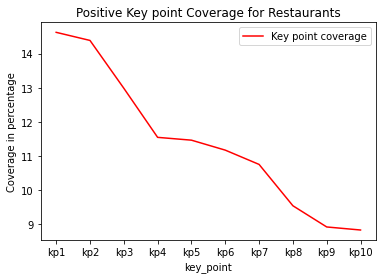

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(y,arr,'r',label='Key point coverage')
plt.xlabel("key_point")

ax.set_xticks(y)
plt.ylabel("Coverage in percentage")
plt.legend()
plt.title("Positive Key point Coverage for Restaurants")

In [ ]:
arr = neg_kp_coverage_top10.to_numpy()
print(arr)

x =list(range(len(arr)))
print(neg_kp_coverage_top10.index)
y= ['kp'+str(xi+1) for xi in x]

[18.40098124 15.50903472 15.1335902  14.53364734 13.31488398 12.59987589
  9.31430767  9.06124322  6.59723294  6.11477989]
Index(['Food is not great but good', 'Slow service, disappointing food',
       'Nothing special and definitely not great',
       'Amazing food but awful service',
       'Terrible service & food was delivered cold',
       'Horrible Service! Bland food!', 'Again, not outstanding, just good',
       'Food was terrible and overpriced',
       'Great atmosphere but terrible food', 'No flavor to anything'],
      dtype='object', name='Key_point')


Text(0.5, 1.0, 'Negative Key point Coverage for Restaurants')

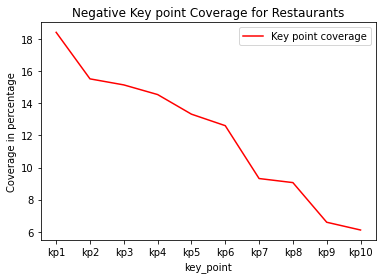

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(y,arr,'r',label='Key point coverage')
plt.xlabel("key_point")

ax.set_xticks(y)
plt.ylabel("Coverage in percentage")
plt.legend()
plt.title("Negative Key point Coverage for Restaurants")

In [ ]:
pos_kp_coverage.to_csv("pos_kp_coverage.csv")

In [ ]:
neg_kp_coverage.to_csv("neg_kp_coverage.csv")